## Upwards LDDMM
Script for show how to to the alignment on tree. 

This example is split up in three sections. 

(1) Initilizaing of butterfly data for example of landmark dynamics

(2) Upwards LDDMM allignment

(3) PCA


In [1]:
import hyperiax
from jax.random import PRNGKey, split
import jax
from jax import numpy as jnp

key = PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## 1, load example data

The example data is made in orcordance with the butterfly shape from Baker et. al. 2024, https://doi.org/10.48550/arXiv.2402.01434
With the modification of 25 landmarks pr wing 

In [13]:
# Create a new Hyperiax client

In [22]:
import pandas as pd
import numpy as np

# Load all files
tree_string = requests.get("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/tree.txt").text
tree = hyperiax.tree.builders.tree_from_newick(tree_string)
landmarks = pd.read_csv("https://raw.githubusercontent.com/MichaelSev/Hyperiax_data/main/landmarks.csv", sep=",", header=None)

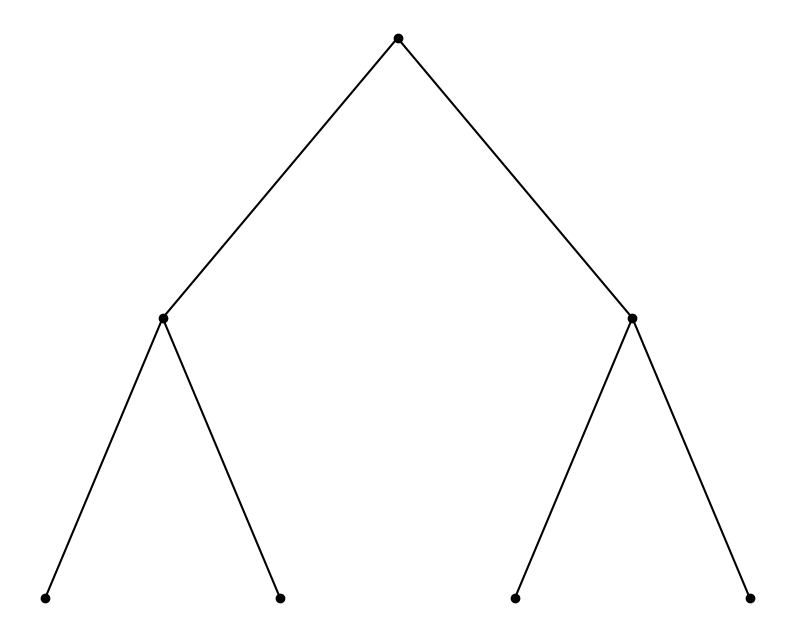

((Graphium_evemon:0.06883,Graphium_sarpedon:0.06835)QS1810:0.13941,(Atrophaneura_dixoni:0.0434,Pachliopta_aristolochiae:0.05484)QS1845:0.16755)QS1804:0;



In [23]:
tree.plot_tree()
print(tree_string)

In [24]:
# The name of the landmarks are placed in the tree, along side with the egdelenght 

# add landmarks
for leaf,l in zip(tree.iter_leaves(),landmarks):
    leaf.data["landmarks"]= jnp.column_stack((landmarks.iloc[l].values[0::2],landmarks.iloc[l].values[1::2]))

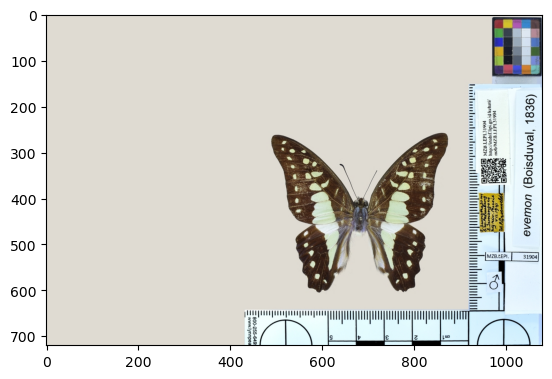

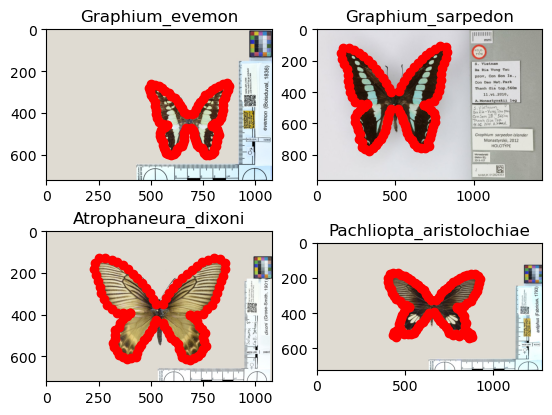

In [32]:
# Example of landmarks 
import matplotlib.pyplot as plt
from PIL import Image

main_path = "https://github.com/MichaelSev/Hyperiax_data/raw/main/image/"

list_of_names =["img0.jpg","img1.jpg","img2.jpg","img3.jpg"]
for leaf,i in zip(tree.iter_leaves(),range(4)):
    plt.subplot(2,2,i+1)
    im = Image.open(requests.get(main_path+list_of_names[i], stream=True).raw)
    implot = plt.imshow(im)
    plt.scatter(leaf.data["landmarks"][:,0],leaf.data["landmarks"][:,1],c="r")
    plt.title(str(leaf.name))




## Part 2 - alignment between two children 

This is from a symmetric tree, with 2 children and a parent. 

In [35]:
# Requires Jaxdifferentalgeometry package
from jaxgeometry.manifolds.landmarks import *   
from jaxgeometry.Riemannian import metric
from jaxgeometry.dynamics import Hamiltonian
from jaxgeometry.Riemannian import Log
from jaxgeometry.dynamics import flow_differential

from hyperiax.execution import LevelwiseTreeExecutor, DependencyTreeExecutor
from hyperiax.models import UpLambda, DownLambda
from hyperiax.models.functional import pass_up

from functools import partial
from scipy.spatial import distance 

In [37]:
# Corresponding to pass_up

up = pass_up('landmarks', 'edge_length')

def fuse(child_landmarks,child_edge_length, **kwargs):
    def lddmm(childxs1,childxs2,parent_placement):

  
        # Estimate the avarage distance between each landmark,
           # if the distance is not approx the same for each set, this shoul dbe the mean of both 
        sigma_k =(np.mean([distance.euclidean(childxs1[i], childxs1[i+1]) for i in range(len(childxs1) - 1)]) +
                np.mean([distance.euclidean(childxs2[i], childxs2[i+1]) for i in range(len(childxs2) - 1)]))/2
        #print(sigma_k,parent_placement)
        n_landmarks = jnp.shape(childxs1)[0]
        
        M = landmarks(n_landmarks,k_sigma=sigma_k*jnp.eye(2)) 
        # Riemannian structure

        metric.initialize(M)
    
        q = M.coords(jnp.vstack(childxs1).flatten())
        v =  (jnp.array(jnp.vstack(childxs2).flatten()),[0])
      
        Hamiltonian.initialize(M)

        # Logarithm map
        Log.initialize(M,f=M.Exp_Hamiltonian)
       
        # Estimate momentum 
        p = M.Log(q,v)[0]

        # Hammilton 
        (_,qps,charts_qp) = M.Hamiltonian_dynamics(q,p,dts(n_steps=100))

        
        #lift
        flow_differential.initialize(M)
        _,dphis,_ = M.flow_differential(qps,dts())
        dphi_t = dphis[parent_placement]
        eta_t = jax.vmap(lambda A,v: jnp.dot(A.T,v))(dphi_t,p.reshape((M.N,M.m)))

        return qps[:,0][parent_placement].reshape(-1,2),eta_t



    parent_placement = int(child_edge_length[0]/sum(child_edge_length)*100)-1 

   
    lddmm_landmarks, lddmm_eta_left  = lddmm(child_landmarks[0],child_landmarks[1],parent_placement)
    _, lddmm_eta_right = lddmm(child_landmarks[1],child_landmarks[0],100-parent_placement)
    

    return {'landmarks':lddmm_landmarks,"eta_left":lddmm_eta_left,"eta_right":lddmm_eta_right}

  

In [38]:
upmodel = UpLambda(up, fuse)
root_exe = DependencyTreeExecutor(upmodel, batch_size=100)
calc_tree = root_exe.up(tree)

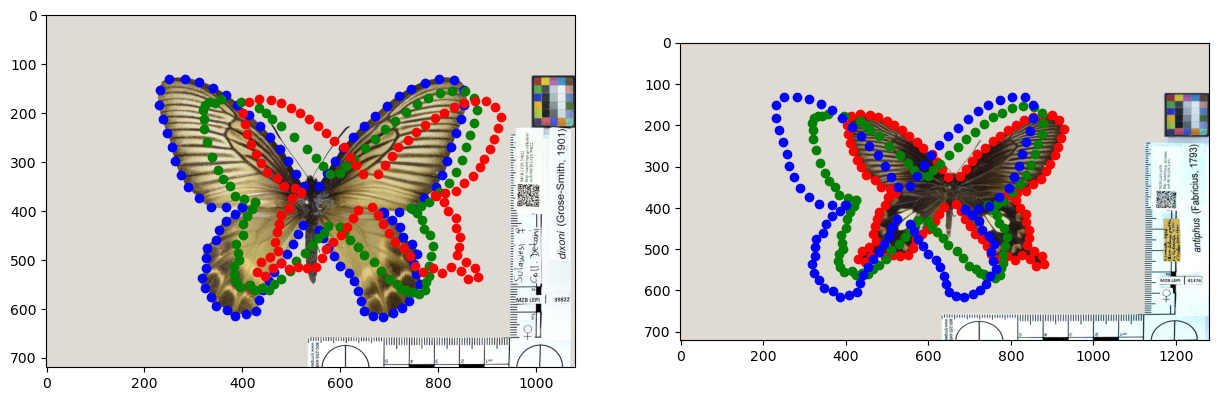

In [39]:
# Illustrate the results
# Illustrative that we got it correctly 
plt.subplot(1, 2, 1)
# Load image 
im = Image.open(requests.get(main_path+"img2.jpg", stream=True).raw)
implot = plt.imshow(im)

# PLot points
plt.scatter(calc_tree.root.children[1].children[0].data["landmarks"][:,0], calc_tree.root.children[1].children[0].data["landmarks"][:,1], color='blue')
plt.scatter(calc_tree.root.children[1].data["landmarks"][:,0], calc_tree.root.children[1].data["landmarks"][:,1], color='g')
plt.scatter(calc_tree.root.children[1].children[1].data["landmarks"][:,0], calc_tree.root.children[1].children[1].data["landmarks"][:,1], color='red')

#plt.scatter(calc_tree.root.data["landmarks"][:,0], calc_tree.root.data["landmarks"][:,1], color='green')
#plt.scatter(calc_tree.root.children[0].children[1].data["landmarks"][:,0], calc_tree.root.children[0].children[1].data["landmarks"][:,1], color='red')

plt.subplot(1, 2, 2)
# load image
im = Image.open(requests.get(main_path+"img3.jpg", stream=True).raw)
implot = plt.imshow(im)

# PLot points
plt.scatter(calc_tree.root.children[1].children[1].data["landmarks"][:,0], calc_tree.root.children[1].children[1].data["landmarks"][:,1], color='red')
plt.scatter(calc_tree.root.children[1].data["landmarks"][:,0], calc_tree.root.children[1].data["landmarks"][:,1], color='g')
plt.scatter(calc_tree.root.children[1].children[0].data["landmarks"][:,0], calc_tree.root.children[1].children[0].data["landmarks"][:,1], color='blue')

#plt.scatter(calc_tree.root.data["landmarks"][:,0], calc_tree.root.data["landmarks"][:,1], color='green')
#plt.scatter(calc_tree.root.children[0].children[0].data["landmarks"][:,0], calc_tree.root.children[0].children[0].data["landmarks"][:,1], color='blue')

plt.show()


In [41]:
# Cumulate all the etas from root til each leaf node 

def flow_eta(tree):
    k = 0 
    for level in tree.iter_levels():
        if len(level) == 1:
            level[0].data["eta_cumulative"] = 0
            continue

        for node in level:
            if k == 0: 
                node.data['eta_cumulative'] = node.parent.data['eta_cumulative']
                node.data['eta_cumulative'] += node.parent.data["eta_left"]
                k += 1
            elif k == 1: 
                node.data['eta_cumulative'] = node.parent.data['eta_cumulative']
                node.data['eta_cumulative'] += node.parent.data["eta_right"]
            
                k -= 1
            else:
                print("Error")
    return tree

In [43]:
# Flow eta down and collect in leafs
calc_tree = flow_eta(calc_tree)

# Get eta from each leaf
leaf_eta = []
for node in calc_tree.iter_leaves():
    leaf_eta.append(node.data["eta_cumulative"].flatten())

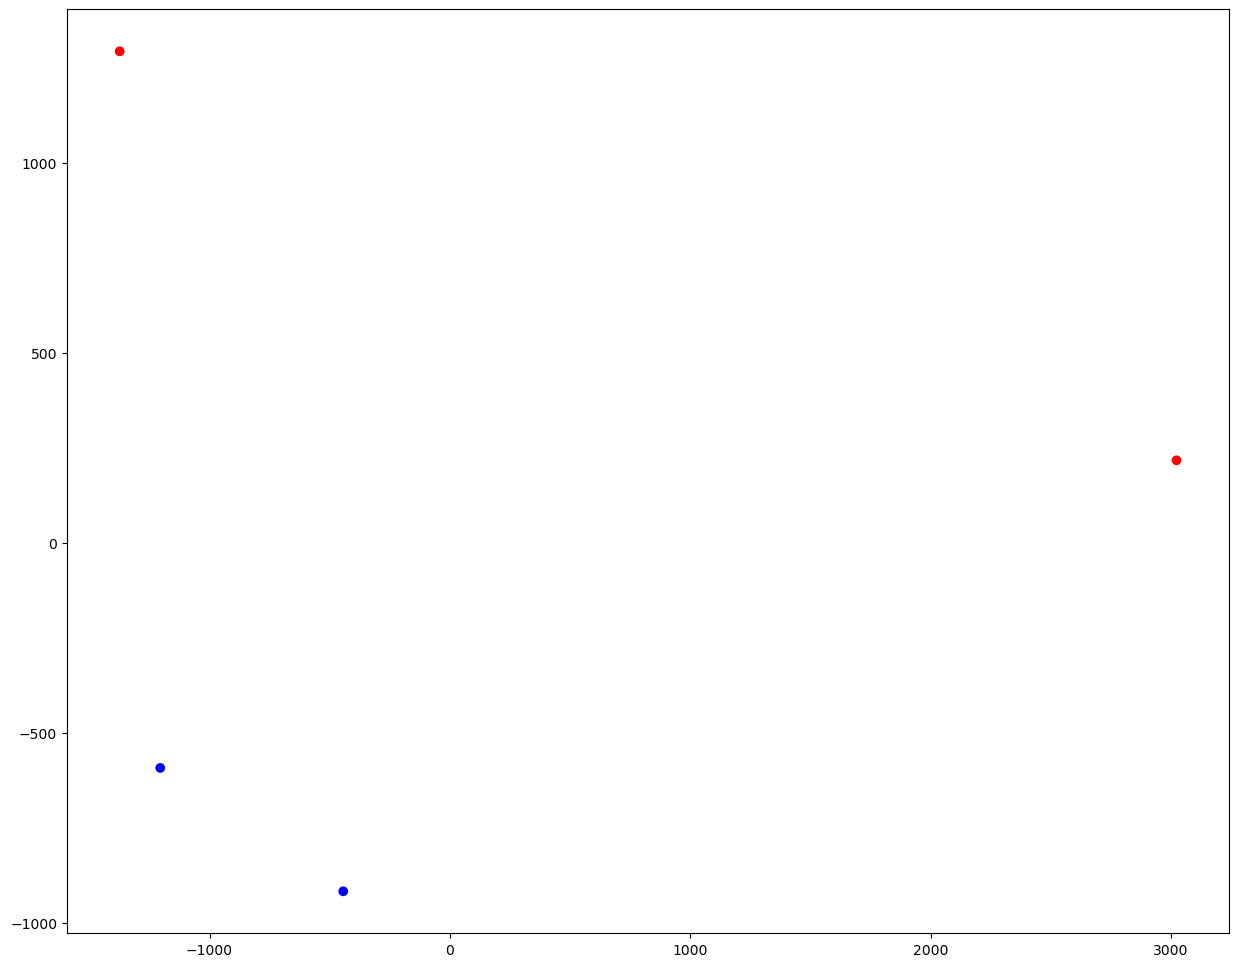

In [44]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(np.array(leaf_eta))
pca.transformed_Logs = pca.transform(np.array(leaf_eta))
plt.scatter(pca.transformed_Logs[:,0],pca.transformed_Logs[:,1],color=["r","r","b","b"])